#  Two-Compartment IV Bolus Pharmacokinetic Model

This notebook models a **two-compartment pharmacokinetic (PK)** system for an intravenous (IV) bolus dose.  
We simulate the drug distribution and elimination, add synthetic observed data (with noise), and estimate parameters using **nonlinear least squares fitting**.

---

##  1. Import Required Libraries
We will use:
- `numpy` for numerical computation  
- `matplotlib` for plotting  
- `scipy.integrate.solve_ivp` for solving differential equations  
- `scipy.optimize.least_squares` for parameter estimation


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy as sp
from scipy.optimize import least_squares

##  2. Define the Two-Compartment ODE System

We consider two compartments:
- **Central compartment (A₁)** – where the drug is administered and eliminated  
- **Peripheral compartment (A₂)** – where the drug distributes temporarily  

The model equations are:

\[
\frac{dA_1}{dt} = -(k_{01} + k_{12})A_1 + k_{21}A_2
\]
\[
\frac{dA_2}{dt} = k_{12}A_1 - k_{21}A_2
\]

where  
- \(k_{01}\): elimination rate constant (from central)  
- \(k_{12}\): distribution rate constant (central → peripheral)  
- \(k_{21}\): redistribution rate constant (peripheral → central)


In [3]:
def two_component_ode(t, y, k01, k12, k21):
    A1, A2 = y
    dA1_by_dt = -(k01 + k12)*A1 + k21*A2
    dA2_by_dt = -k21*A2 + k12*A1
    return [dA1_by_dt, dA2_by_dt]

##  3. Function to Solve the ODEs

This function integrates the ODEs using `solve_ivp` and returns:
- Amounts in each compartment (A₁, A₂)
- Corresponding concentrations (C₁ = A₁/V₁, C₂ = A₂/V₂)


In [4]:
def solution_ivp(params, times, y0):
    V1, V2, k10, k12, k21 = params 
    sol = solve_ivp(lambda tt, y: two_component_ode(tt, y, k10, k12, k21), (times[0], times[-1]), y0, t_eval = times)
    A1, A2 = sol.y
    C1 = A1/V1
    C2 = A2/V2
    return C1, A1, C2, A2

##  4. Define True Model Parameters and Simulate "True" Concentrations

We assume a 500 mg IV bolus dose given into the **central compartment**.


In [5]:
dose = 500        # mg (IV bolus dose)
V1 = 20           # L (volume of central compartment)
V2 = 15           # L (volume of peripheral compartment)
# rate constants (1/hr)
k10 = 0.2   # elimination
k12 = 0.3   # distribution (central → peripheral)
k21 = 0.1   # redistribution (peripheral → central)
y0 = [dose, 0]
times = np.linspace(0, 24, 201)
params_true = [V1, V2, k10, k12, k21]

C1_true, A1_true, C2_true, A2_true = solution_ivp(params_true, times, y0)


## 5. Generate Synthetic Observed Data

We simulate noisy observed concentrations by adding Gaussian noise (σ = 0.3 mg/L) to the model predictions.

In [6]:
def observed_data(C1, C2):
    C1_obs = C1 + np.random.normal(0, 0.3, len(C1))
    C2_obs = C2 + np.random.normal(0, 0.3, len(C2))
    return C1_obs, C2_obs

C1_obs, C2_obs = observed_data(C1_true, C2_true)

##  6. Define the Residual Function for Parameter Fitting

We define residuals as the difference between observed and model-predicted concentrations.  
The fitting will adjust parameters `[V1, V2, k10, k12, k21]` to minimize the sum of squared residuals.

In [7]:
def residuals_pk(p):
    # Avoid unphysical parameters
    if np.any(np.array(p) <= 0):
        return 1e6 * np.ones(2 * len(times))
    C1_model, A1_model, C2_model, A2_model = solution_ivp(p, times, y0)
    res = np.concatenate([(C1_model - C1_obs), (C2_model - C2_obs)])
    return res

## 7. Parameter Estimation using Nonlinear Least Squares

We use `scipy.optimize.least_squares` to find the parameters that minimize the residuals.


In [8]:
p0 = [40.0, 40.0, 0.12, 0.12, 0.12]  # guess for V and k_el
# bounds to keep physically reasonable
lower = [1e-3, 1e-3, 1e-6, 1e-6, 1e-6]
upper = [1000.0, 1000.0, 10.0, 10.0, 10.0]

res = least_squares(residuals_pk, p0, bounds=(lower, upper))
print("Estimated parameters:", res.x)

Estimated parameters: [20.03374978 15.08190104  0.19908455  0.30234513  0.09993834]


##  8. Compare Model Fit vs Observed Data
We visualize how well the fitted model reproduces the observed (noisy) concentration–time profiles for both compartments.

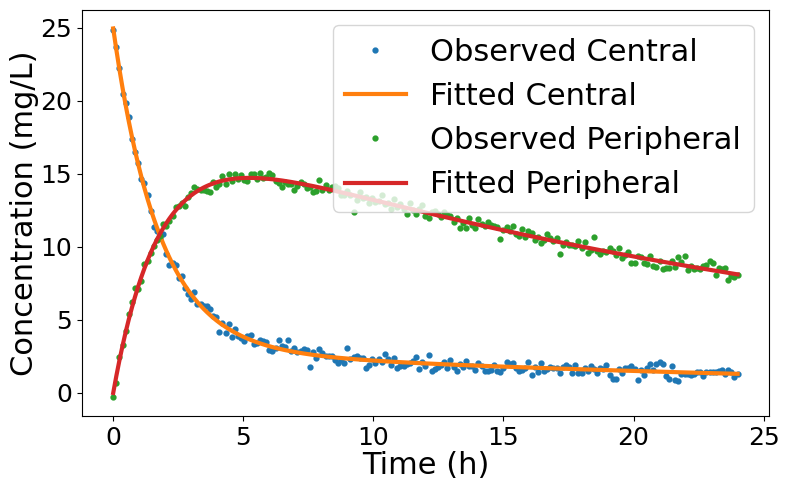

In [9]:
# Compare model fit
C1_fit, A1_fit, C2_fit, A2_fit = solution_ivp(res.x, times, y0)

plt.figure(figsize=(8, 5))
plt.plot(times, C1_obs, 'o', label="Observed Central", markersize=3)
plt.plot(times, C1_fit, '-', label="Fitted Central")
plt.plot(times, C2_obs, 'o', label="Observed Peripheral", markersize=3)
plt.plot(times, C2_fit, '-', label="Fitted Peripheral")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (mg/L)")
plt.legend()
plt.tight_layout()
plt.show()
    